<a href="https://colab.research.google.com/github/zhiyuan-95/db-vae/blob/main/comet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
!pip install comet_ml --quiet
import comet_ml
from comet_ml import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

what I am trying to do is that I want to prove that the given method can produce a better standard cnn. which means that the validation score would reduce as the increasing epoch.

In [172]:
from functools import partial

EPOCH_PARAM_NAMES = {'batch_size', 'learning_rate','smoothing_fact'}

def _experiment_to_row(e, param_names=None):
    metric_summaries = {sm['name']: sm for sm in e.get_metrics_summary()}
    def mget(name, key, default=np.nan, cast_float=True):
        sm = metric_summaries.get(name)
        if sm is None:
            return default
        val = sm.get(key, default)
        if cast_float and val is not None and not isinstance(val, float):
            try:
                return float(val)
            except Exception:
                return default
        return val

    best_epoch = mget('val', 'stepMax')
    if not np.isnan(best_epoch):best_epoch += 1
    stop_epoch = mget('val', 'stepCurrent')
    if not np.isnan(stop_epoch):stop_epoch += 1

    best_val = mget('val', 'valueMax')
    row = {
        "exp_key": getattr(e, "key", None),
        "stop_epoch": stop_epoch,
        "best_val"  : best_val,
        "best_epoch": best_epoch,
    }

    allowed = set(param_names) if param_names is not None else EPOCH_PARAM_NAMES
    params = {}
    for p in e.get_parameters_summary():
        name = p.get("name")
        if name in allowed:
            params[name] = p.get("valueCurrent", None)
    params.update(row)
    return params

def get_param_metric_records(experiments, param_names=None):
    mapper = partial(_experiment_to_row, param_names=param_names)
    rows = list(map(mapper, experiments))
    df = pd.DataFrame(rows)
    df.index = df.index + 1
    return df

In [173]:
def plot(comet,record,y):
    if comet.model == 'dbvae':
        params = [
            ['batch_size', 'learning_rate'],
            ['smoothing_fac','latent_dim']
        ]
        for i in range(len(params)):
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            for j in range(len(params[i])):
                ax[j].scatter(record[params[i][j]], record[y])
                ax[j].set_xlabel(params[i][j])
                ax[j].set_ylabel(y)
                ax[j].set_title(f"{params[i][j]} vs. {y}")
                ax[j].grid(True)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()

    elif comet.model == 'standard':
        params = ['batch_size', 'learning_rate']
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        for i in range(len(params)):
            ax[j].scatter(record[params[i][j]], record[y])
            ax[j].set_xlabel(params[i][j])
            ax[j].set_ylabel(y)
            ax[j].set_title(f"{params[i][j]} vs. {y}")
            ax[j].grid(True)
        for sub_ax in fig.get_axes():
            sub_ax.label_outer()
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

In [174]:
# --- 1) pick representative trial per hyperparameter set ---
def pick_representatives(record: pd.DataFrame, by_params, measure):
    grouped = record.groupby(by_params, dropna=False)
    reps = []

    for params, group in grouped:
        vals = group['best_val']
        if vals.dropna().empty:
            continue

        if measure == "max":
            idx = vals.idxmax()

        elif measure == "median":
            med = vals.median()
            idx = (vals - med).abs().idxmin()

        else:
            raise ValueError(f"Unknown measure '{measure}'. Use 'max' or 'median'.")

        if pd.notna(idx):
            reps.append(idx)

    return reps



def metrics_at_epoch(exp, epoch, names=('loss_ema','val','dbval')):
    # build per-metric -> {step: value}
    store = {n: {} for n in names}
    for m in exp.get_metrics():
        name = m['metricName']
        if name in store:
            step = int(m['step'])
            store[name][step] = float(m['metricValue'])

    # Some notebooks log epoch starting at 0, some at 1.
    # Try exact epoch first; if missing, try epoch-1 as a fallback.
    out = {}
    for n in names:
        if epoch in store[n]:
            out[n] = store[n][epoch]
        elif (epoch - 1) in store[n]:
            out[n] = store[n][epoch - 1]
        else:
            out[n] = float('nan')
    return out

def build_summary(model,measure, by_params):
    record = model.record
    exps = model.experiments
    # Step 1: pick the representative trial (median best_val) for each hyperparameter group
    best_idx = pick_representatives(record, by_params, measure)
    # Step 2: define a helper function that will run on each record
    def get_metrics_for_row(row):
        # exp indices are 0-based, record indices are 1-based (from get_param_metric_records)
        exp = exps[row.name - 1]
        best_epoch = int(row['best_epoch'])
        best_val = float(row['best_val'])

        # Extract metrics at that epoch
        metrics = metrics_at_epoch(exp, best_epoch-1, names=('loss_ema','val','dbval'))
        return pd.Series({
            'exp_key': row['exp_key'],
            f'loss_at_{measure}': metrics['loss_ema'],
            f'val_at_{measure}': metrics['val'],
            f'dbval_at_{measure}': metrics['dbval'],
            'best_epoch': best_epoch,
            'best_val': best_val,
        })

    # Step 3: apply `map` (or technically pandas `apply`) to selected records
    selected_records = record.loc[best_idx]
    metrics_summary = selected_records.apply(get_metrics_for_row, axis=1)

    # Step 4: merge param columns + metrics summary
    param_cols = record.columns.intersection(by_params)
    summary_df = pd.concat([selected_records[param_cols].reset_index(drop=True),
                            metrics_summary.reset_index(drop=True)], axis=1)

    return summary_df.sort_values(by=f'val_at_{measure}', ascending=False).reset_index(drop=True)

In [175]:
def get_metric_names(model):
  metricName = []
  for x in model.experiments[0].get_metrics():
    if x['metricName'] not in metricName and x['metricName'][:3]!='sys':
      metricName.append(x['metricName'])
  print(sorted(metricName))

In [176]:
def project_name(c):
  name = 'dbvae-c'
  for x in range(3):
    if len(str(c[x]))==1: name+=f'-{c[x]}'
    else: name+=f'-{str(c[x])[0]}-{str(c[x])[2:]}'
  return name


In [177]:
class comet():
  def __init__(self, model,measure, c=None ,expmt=1):
    COMET_API_KEY = "ROr5Iwf4PjYLL2ZhtmHtYHhoP"
    self.api = API(COMET_API_KEY)
    self.workspace = "zhiyuan-jin"
    self.model = model
    if model == 'standard':
      self.projectName = "standard-p-3"
      self.params = ['batch_size', 'learning_rate']
    elif model == 'debiasing':#dbvae-c-1-0-2-0-0002
      self.projectName = project_name(c)
      self.params = ['batch_size', 'learning_rate', 'smoothing_fact']
    try:
      self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
    except Exception as e:
      print(f"Error: Could not find project '{self.projectName}' in workspace '{self.workspace}'. Please check the project name and workspace in Comet ML.")
      raise e
    self.record = get_param_metric_records(self.experiments, self.params)
    self.top_records = None
    self.summary = build_summary(self, measure, self.params)
  def delete_record_comet(self, keys):
    print('are you sure you want to delate following records?: ')
    for x in keys:
      print(x)
    answer = input('')
    if answer == 'yes':
      for key in keys:
        self.api.delete_experiment(key)
        print(f"Deleted experiment {key}")
      self.experiments = self.api.get(project_name=self.projectName, workspace="zhiyuan-jin")
      self.record = get_param_metric_records(self.experiments,self.params)
    else:
      print('not deleted')
  def plot_relation(self, x,y):
    if x == 'learning_rate': X = [float(l) for l in self.summary['learning_rate']]
    elif x == 'batch_size': X = [int(l) for l in self.summary['batch_size']]
    elif y == 'batch_size': Y = [int(l) for l in self.summary['batch_size']]
    else: X = self.summary[x]
    Y = self.summary[y]
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs. {y} across Experiments")
    plt.grid(True)
    plt.show()
  def delete_nan_validation(self, confirm=True):
      nan_columns = self.v.columns[self.v.iloc[-1].isna()]
      nan_exps = self.record.loc[nan_columns.to_list()]
      if nan_exps.empty:
          print("✅ No experiments with NaN validation found.")
          return
      print(f"⚠️ Found {len(nan_exps)} experiments with NaN validation:")
      print(nan_exps[['exp_key', 'exp_name', 'validation']])
      if not confirm:
          answer = 'yes'
      else:
          answer = input("Type 'yes' to confirm deletion: ")
      if answer.lower() == 'yes':
          for key in nan_exps['exp_key']:
              try:
                  self.api.delete_experiment(key)
                  print(f"Deleted experiment {key}")
              except Exception as e:
                  print(f"❌ Failed to delete {key}: {e}")
          # Refresh records
          self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
          self.record = get_param_metric_records(self.experiments, self.params)
          print("✅ Refresh complete. Updated experiment list loaded.")
      else:
          print("⏩ Deletion cancelled.")
  def loss_decompose(self,exp):
    total, classification,vae = [],[],[]
    for x in self.experiments[exp].get_metrics():
      if x['metricName']=='loss': total.append(float(x['metricValue']))
      elif x['metricName']=='classification': classification.append(float(x['metricValue']))
      elif x['metricName']=='vae': vae.append(float(x['metricValue']))
    plt.plot(total, label='Total Loss')
    plt.plot(classification, label='classification')
    plt.plot(vae, label='vae')
    plt.legend()
    plt.show()
  def val_trend(self,key):
    val, dbval = [],[]
    for x in self.api.get_experiment_by_key(key).get_metrics():
      if x['metricName']=='val': val.append(float(x['metricValue']))
      elif x['metricName']=='dbval': dbval.append(float(x['metricValue']))
    plt.plot(val, label='val')
    plt.plot(dbval, label='dbval')
    plt.legend()
    plt.show()
  def delete_incomplete_experiment_groups(self, expected_trials=3, confirm=True):
    """
    Delete all experiment trials for groups that contain fewer than expected_trials.

    A "group" means same (batch_size, learning_rate, smoothing_fact)
    depending on self.params.
    """

    # Step 1: count experiments per hyperparameter set
    group_counts = self.record.groupby(self.params)['exp_key'].count()

    # Step 2: find incomplete groups
    incomplete = group_counts[group_counts < expected_trials]

    if incomplete.empty:
        print(f"✅ All experiment groups have at least {expected_trials} trials.")
        return

    print("⚠️ Found incomplete groups (less than expected trials):")
    print(incomplete)

    # Step 3: collect all exp_keys belonging to incomplete groups
    keys_to_delete = []

    for params, _ in incomplete.items():
        batch = self.params
        # filter record rows matching these params
        mask = (self.record[batch[0]] == params[0])
        for i in range(1, len(batch)):
            mask &= (self.record[batch[i]] == params[i])
        keys_to_delete.extend(self.record[mask]['exp_key'].tolist())

    print("\nExperiments to be deleted:")
    for k in keys_to_delete:
        print(" -", k)

    # Step 4: confirmation
    if confirm:
        ans = input("\nType 'yes' to confirm deletion: ")
        if ans.lower() != "yes":
            print("❌ Deletion cancelled.")
            return

    # Step 5: delete through Comet API
    print("\nDeleting experiments...")
    for key in keys_to_delete:
        try:
            self.api.delete_experiment(key)
            print(f"Deleted {key}")
        except Exception as e:
            print(f"❌ Failed to delete {key}: {e}")

    # Step 6: refresh state
    self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
    self.record = get_param_metric_records(self.experiments, self.params)
    print("✅ Refresh complete.")


In [178]:
def get_epoch_avg_history(model, metric='dbval', smoothing_col='smoothing_fact'):
    """
    If smoothing_col exists in model.summary:
        return dict {smoothing_value: avg_traj_series}
    Else:
        return dict {'all': avg_traj_series}
    """
    has_smoothing = smoothing_col in model.summary.columns

    # -------------------------
    # Case 1: Standard CNN
    # -------------------------
    if not has_smoothing:
        print(f'standard cnn with {model.summary.shape[0]} reps...')
        trajectories = []
        for _, row in model.summary.iterrows():
            exp_key = row['exp_key']
            best_epoch = int(row['best_epoch'])

            try:
                exp = model.api.get_experiment_by_key(exp_key)
                metrics = exp.get_metrics()

                vals = {}
                for m in metrics:
                    if m['metricName'] == metric:
                        step = int(m['step'])
                        if step < best_epoch:
                            vals[step] = float(m['metricValue'])

                if vals:
                    trajectories.append(pd.Series(vals))

            except Exception as e:
                print(f"Failed to fetch metrics for {exp_key}: {e}")

        if trajectories:
            df = pd.concat(trajectories, axis=1)
            mean_traj = df.mean(axis=1).sort_index()
        else:
            mean_traj = pd.Series(dtype=float)

        return {'all': mean_traj}

    # -------------------------
    # Case 2: DBVAE (group by smoothing_fact)
    # -------------------------
    results = {}
    for sm_val, sm_group in model.summary.groupby(smoothing_col):
        print(f"Processing dbvae smoothing={sm_val} with {len(sm_group)} reps...")

        trajectories = []

        for _, row in sm_group.iterrows():
            exp_key = row['exp_key']
            best_epoch = int(row['best_epoch'])

            try:
                exp = model.api.get_experiment_by_key(exp_key)
                metrics = exp.get_metrics()

                vals = {}
                for m in metrics:
                    if m['metricName'] == metric:
                        step = int(m['step'])
                        if step < best_epoch:
                            vals[step] = float(m['metricValue'])

                if vals:
                    trajectories.append(pd.Series(vals))

            except Exception as e:
                print(f"Failed to fetch metrics for {exp_key}: {e}")

        if trajectories:
            df = pd.concat(trajectories, axis=1)
            mean_traj = df.mean(axis=1).sort_index()
        else:
            mean_traj = pd.Series(dtype=float)

        results[sm_val] = mean_traj

    return results


In [179]:
measure = 'median'
standard = comet('standard', measure)

In [180]:
#c =(1,0.2,0.0002)
c = (1,1,0.0002)
dbvae = comet('debiasing',measure, c)

In [181]:
#dbvae.summary.loc[(dbvae.summary.smoothing_fact=='0.6')]#

In [182]:
#standard.plot_relation('loss_at_max', 'val_at_max')

In [183]:
standard_summary = standard.summary[f'dbval_at_{measure}'].describe()
dbvae_summary = dbvae.summary[f'dbval_at_{measure}'].describe()
combined_summary = pd.DataFrame({'standard': standard_summary, 'dbvae': dbvae_summary})
display(combined_summary)

,standard,dbvae
count,57.000000,150.000000
mean,0.216368,0.220083
std,0.085820,0.092546
min,0.087694,0.029361
25%,0.160294,0.160631
50%,0.196450,0.212246
75%,0.270747,0.283522
max,0.465252,0.501687


standard cnn with 57 reps...
Processing dbvae smoothing=0.6 with 51 reps...
Processing dbvae smoothing=1 with 59 reps...
Processing dbvae smoothing=1.4 with 40 reps...


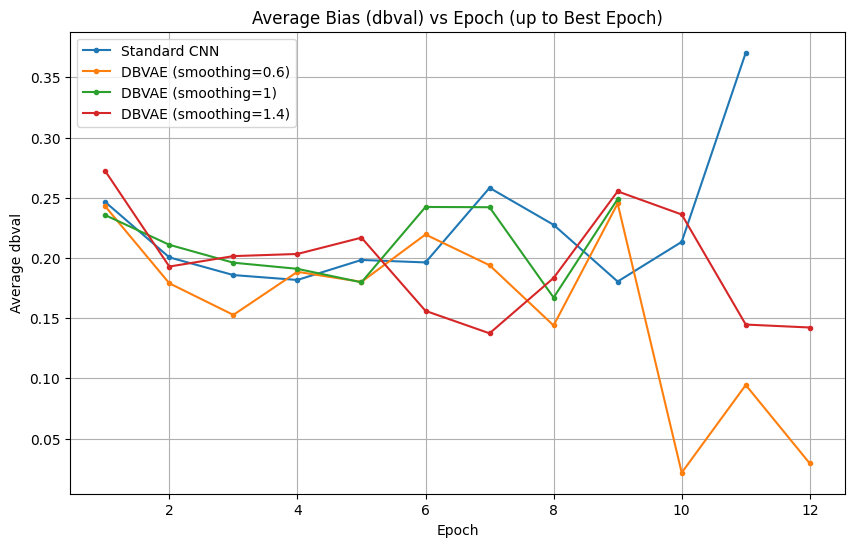

In [184]:
# Calculate average trajectories at each epoch across the experiments
metrix = 'dbval'# 'val'

std_traj_dict = get_epoch_avg_history(standard, metrix)
dbvae_traj_dict = get_epoch_avg_history(dbvae, metrix)

# Plotting
plt.figure(figsize=(10, 6))

# --- Standard CNN: only one curve ---
std_traj = std_traj_dict.get('all', pd.Series(dtype=float))
if not std_traj.empty:
    plt.plot(std_traj.index + 1, std_traj.values,
             label='Standard CNN', marker='.')

# --- DBVAE: curves for each smoothing_fact ---
for sm_val, traj in dbvae_traj_dict.items():
    if traj is None or traj.empty:
        continue
    plt.plot(traj.index + 1, traj.values,
             label=f'DBVAE (smoothing={sm_val})', marker='.')

plt.xlabel('Epoch')
plt.ylabel(f'Average {metrix}')
plt.title(f'Average Bias ({metrix}) vs Epoch (up to Best Epoch)')
plt.legend()
plt.grid(True)
plt.show()


In [185]:
metrics_val =  get_epoch_avg_history(dbvae, 'val')
metrics_dbval = get_epoch_avg_history(dbvae, 'dbval')

Processing dbvae smoothing=0.6 with 51 reps...
Processing dbvae smoothing=1 with 59 reps...
Processing dbvae smoothing=1.4 with 40 reps...
Processing dbvae smoothing=0.6 with 51 reps...
Processing dbvae smoothing=1 with 59 reps...
Processing dbvae smoothing=1.4 with 40 reps...


In [186]:
Vae = []
Dbvae = []

# Collect all trajectories and find the maximum length
all_vae_trajectories = [list(sm) for sm in metrics_val.values()]
all_dbvae_trajectories = [list(sm) for sm in metrics_dbval.values()]

max_len_vae = 0
if all_vae_trajectories:
    max_len_vae = max(len(t) for t in all_vae_trajectories)

max_len_dbvae = 0
if all_dbvae_trajectories:
    max_len_dbvae = max(len(t) for t in all_dbvae_trajectories)

# Pad shorter trajectories with NaN to match the maximum length
for traj in all_vae_trajectories:
    Vae.append(traj + [np.nan] * (max_len_vae - len(traj)))

for traj in all_dbvae_trajectories:
    Dbvae.append(traj + [np.nan] * (max_len_dbvae - len(traj)))

Vae = np.array(Vae)
Dbvae = np.array(Dbvae)
comb = Vae-2*Dbvae

In [187]:
std_val = get_epoch_avg_history(standard, 'val')
std_dbval = get_epoch_avg_history(standard, 'dbval')


standard cnn with 57 reps...
standard cnn with 57 reps...


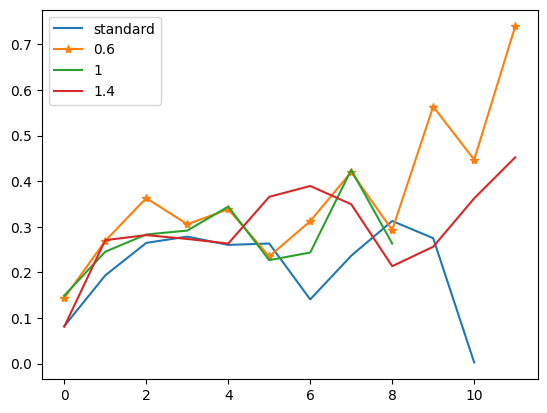

In [188]:
std_comb = std_val['all']-2*std_dbval['all']
plt.plot(std_comb, label = 'standard')

plt.plot(comb[0,:], label = '0.6', marker = '*')
plt.plot(comb[1,:],label = '1')
plt.plot(comb[2,:], label = '1.4')
plt.legend()
plt.show()